### Install Packages

First, we begin from loading packages.

In [1]:
library(grid)
library(lattice) 

To access the overall package documentation, type

In [2]:
#library(ChainLadder)

In [3]:
#demo(package="ChainLadder")

In [4]:
#vignette('ChainLadder', package='ChainLadder')

### Development Triangle

Reading the given dataset into R.

In [5]:
rawdata <- read.csv("datasets/ppauto_pos.csv")
tail(rawdata)

,GRCODE,GRNAME,AccidentYear,DevelopmentYear,DevelopmentLag,IncurLoss_B,CumPaidLoss_B,BulkLoss_B,EarnedPremDIR_B,EarnedPremCeded_B,EarnedPremNet_B,Single,PostedReserve97_B
14595,43494,American Hallmark Ins Co Of TX,1997,2001,5,5587,5537,0,32271,22646,9625,1,4527
14596,43494,American Hallmark Ins Co Of TX,1997,2002,6,5588,5549,0,32271,22646,9625,1,4527
14597,43494,American Hallmark Ins Co Of TX,1997,2003,7,5571,5567,0,32271,22646,9625,1,4527
14598,43494,American Hallmark Ins Co Of TX,1997,2004,8,5577,5577,0,32271,22646,9625,1,4527
14599,43494,American Hallmark Ins Co Of TX,1997,2005,9,5576,5576,0,32271,22646,9625,1,4527
14600,43494,American Hallmark Ins Co Of TX,1997,2006,10,5573,5576,-3,32271,22646,9625,1,4527


Instead of having the data separated by insurance company, we will sum the data subsets of the cumulative paid losses; then we will arrange the information by accident year and development lag.

In [6]:
.allisnumeric <- function (x, what = c("test", "vector"), extras = c(".", "NA")){
    
  # Based on code by Frank Harrell, Hmisc package, licence: GPL >= 2
  what <- match.arg(what)
  x <- sub("[[:space:]]+$", "", x)
  x <- sub("^[[:space:]]+", "", x)
  #xs <- x[x %nin% c("", extras)]
  xs <- x[match(x, extras, nomatch = 0) == 0]
  isnum <- suppressWarnings(!any(is.na(as.numeric(xs))))
  if (what == "test")
    isnum
  else if (isnum)
    as.numeric(x)
  else x
}

In [7]:
incr2cum <- function(Triangle, na.rm=FALSE){
    
  if(na.rm){
    upper <- col(Triangle) <= ncol(Triangle) + 1 - row(Triangle)
    upperna <- which(is.na(Triangle[upper]), arr.ind=TRUE)
    Triangle[upper][upperna] <- 0
  }
  cum <- t(apply(Triangle,1, cumsum))
  dimnames(cum) <- dimnames(Triangle)
  expos <- attr(Triangle,"exposure")
  if (!is.null(expos))
    attr(cum,"exposure") <- expos
  class(cum) <- c("triangle", "matrix")
  cum
}

In [8]:
cum2incr <- function(Triangle){
  incr <- cbind(Triangle[,1], t(apply(Triangle,1,diff)))
  dimnames(incr) <- dimnames(Triangle)
  expos <- attr(Triangle,"exposure")
  if (!is.null(expos))
    attr(incr,"exposure") <- expos
  class(incr) <- c("triangle", "matrix")
  incr
}

In [9]:
as.triangle <- function(Triangle, origin="origin", dev="dev", value="value",...){
  UseMethod("as.triangle")
}

In [10]:
as.triangle.matrix <- function(Triangle, origin="origin", dev="dev", value="value",...){
    
  class(Triangle) <- c("triangle", "matrix")
  if(is.null(dimnames(Triangle))){
    dimnames(Triangle) <- list(origin=1:nrow(Triangle), dev=1:ncol(Triangle))
  }
  names(dimnames(Triangle)) <- c(origin, dev)

  if(is.null(dimnames(Triangle)[[origin]])){
    dimnames(Triangle)[[origin]] <- 1:nrow(Triangle)
  }
  if(is.null(dimnames(Triangle)[[dev]])){
    dimnames(Triangle)[[dev]] <- 1:ncol(Triangle)
  }
  storage.mode(Triangle) <- "double"
  return(Triangle)
}

In [11]:
as.triangle.data.frame <- function(Triangle, origin="origin", dev="dev", value="value", ...){
  
  # aggregate claims data
  aggTriangle <- stats::aggregate(Triangle[[value]], list(Triangle[[dev]], Triangle[[origin]]), sum)
  names(aggTriangle) <- c(dev, origin, value)
  origin_names <- as.character(unique(aggTriangle[, origin]))
  dev_names <-  as.character(unique(aggTriangle[, dev]))
  
  # reshape into wide format
  tria <- stats::reshape(aggTriangle, 
                  v.names=value, 
                  timevar = dev, 
                  idvar = origin, 
                  direction = "wide", 
                  new.row.names = origin_names)[, -1]
  
  matrixTriangle <- as.matrix(tria)
  names(dimnames(matrixTriangle)) <- c(origin, dev)
  dimnames(matrixTriangle)[[1]] <- origin_names
  dimnames(matrixTriangle)[[2]] <- dev_names
  matrixTriangle <- matrixTriangle[order(nchar(origin_names), origin_names), order(nchar(dev_names), dev_names)]
  class(matrixTriangle) <- c("triangle", "matrix")
  return(matrixTriangle)
}

In [12]:
triangle <- function(..., bycol = FALSE, origin = "origin", dev = "dev", value = "value"){
    
  x <- list(...)
  if (length(x) == 1L) {
    ## 'len' contains the number of development periods (when filling by row) or origin periods (when filling by column). In the case
    ## where there is only one vector of data provided, 'len' is the positive root of n(n + 1)/2 = k, where k is the number of data
    ## points.
    len <- (-1 + sqrt(1 + 8 * length(x[[1L]])))/2
    ## Error if 'len' is not an integer, otherwise it is just too complicated to try infer what user wants. (Test taken from ?is.integer.)
    if (abs(len - round(len)) > .Machine$double.eps^0.5)
        stop("invalid number of data points for a triangle")
    ## Rearrange the data vector in a list of vectors suitable to build a 'len x len' triangle.
    s <- seq_len(len)                   # avoid generating twice
    x <- split(x[[1L]], rep(s, rev(s)))
  } else {
    ## If more than one data vector is provided in argument, the number of development or origin periods is derived from the
    ## *first* vector (this avoids looking at the length of each and every element to find the maximum).
    len <- length(x[[1L]])
  }
  ## Extend each data vector to length 'len' by filling with NAs and put into matrix form at the same time; dimension names will be in
  ## place thanks to 'sapply'.
  x <- sapply(x, function(x) { length(x) <- len; x })
  ## Turn to 'as.triangle' to complete the work.
  as.triangle.matrix(if (bycol) x else t(x), origin = origin, dev = dev, value = value)
}

In [13]:
as.data.frame.triangle <- function(x, row.names=NULL, optional, lob=NULL, na.rm=FALSE,...){

  longTriangle <- .as.LongTriangle(x, na.rm)
  if(is.null(row.names))
    rownames(longTriangle) <- paste(longTriangle[,1], longTriangle[,2], sep="-")
  if(!is.null(lob))
    longTriangle$lob=lob

  class(longTriangle) <- c("long.triangle", "data.frame")
  return(longTriangle)
}

plot.triangle <- function(x,type="b", xlab="dev. period", ylab=NULL, lattice=FALSE,...){
  .x <- x
  class(.x) <- "matrix"
  if(!lattice){
    matplot(t(.x),type=type, xlab=xlab, ylab=ifelse(is.null(ylab), deparse(substitute(x)), ylab),...)
  }else{
    df <- as.data.frame(as.triangle(.x)) 
    xyplot(value ~ dev | factor(origin), data=df, type=type, as.table=TRUE, xlab=xlab, ylab=ylab, ...)
  }
}

In [14]:
print.triangle <- function(x, ...) {
  ret <- x
  class(x) <- tail(class(x), -1)
  NextMethod(x, ...)
  invisible(ret)
}

In [15]:
.as.MatrixTriangle <- function(x, origin="origin", dev="dev", value="value"){
    
  ## x has to be a data.frame with columns: origin, dev and value
  x <- x[,c(origin, dev, value)]
  names(x) <- c("origin", "dev", "value")
  z <- reshape(x, timevar="dev", v.names="value", idvar="origin", direction="wide")
  z <- z[order(z$origin), ]

  .origin.names <- z$origin
  z <- z[,-1]
  names(z) <- gsub("value.", "",names(z))
  .dev.names <- as.numeric(as.character(names(z)))
  z <- z[,order(.dev.names)]

  z<- as.matrix(z)
  dimnames(z) <- list(origin=.origin.names, dev=sort(.dev.names))
  names(dimnames(z)) <- c(origin, dev)
  return(z)
}

In [16]:
as.LongTriangle <- function (Triangle, varnames = names(dimnames(Triangle)), value.name = "value", na.rm = TRUE) {
    
  if (!inherits(Triangle, "matrix")) stop("asLongTriangle only works for matrices")
  if (is.null(varnames)) varnames <- c("origin", "dev")
  else {
    if (is.na(varnames[1L])) varnames[1L] <- "origin"
    if (is.na(varnames[2L])) varnames[2L] <- "dev"
  }
  namecols <- setNames(expand.grid(dimnames(Triangle), KEEP.OUT.ATTRS = FALSE, stringsAsFactors = TRUE), varnames)
  if (na.rm) {
    isna <- is.na(Triangle)
    namecols <- namecols[!isna,]
    Triangle <- Triangle[!isna]
  }
  y <- cbind(namecols, setNames(data.frame(c(Triangle)), value.name))
  y
}

In [17]:
.as.LongTriangle <- function(Triangle, na.rm=FALSE){
    
  x <- Triangle
  nms <- names(dimnames(x))
  .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
  .origin <- dimnames(x)[[nms[1L]]]
  if(class(dimnames(x)[[nms[2L]]]) %in% "character"){
    if(.allisnumeric(dimnames(x)[[nms[2L]]])){
      .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
    }else{
      .dev <- seq(along=(dimnames(x)[[nms[2L]]]))
      warning(paste(
        c("Development period was a character and has been set to:\n",.dev),
        collapse = " "))
    }
  }else{
    .dev <- try(as.numeric(dimnames(x)[[nms[2L]]]))
  }
  lx <- expand.grid(origin=.origin, dev=.dev, stringsAsFactors = FALSE)
  lx$value <- as.vector(x)
  if(na.rm){
    lx <- na.omit(lx)
  }
  if (!is.null(nms)) {
    if (!is.na(nms[1L])) names(lx)[1L] <- nms[1L]
    if (!is.na(nms[2L])) names(lx)[2L] <- nms[2L]
  }
  return(lx)
}

In [18]:
# A coefficients method to quickly pull out the factors from a ChainLadder model
coef.ChainLadder <- function(object, ...) {
  structure(sapply(object$Models, coefficients), names = head(colnames(object$Triangle), -1), ...)
}

In [19]:
getLatestCumulative <- function (Triangle, na.values = NULL) {
  # Returns the "current diagonal" from a triangle. This is defined to be the vector of entries from the triangle corresponding 
  # to the rightmost non-missing cell per row.
  # Features: 
  # 1. For the "lazy actuary" who leaves zeroes in triangle cells corresponding to future observations, can specify 
  #     na.values=0 to find the rightmost non-zero and non-NA entry.
  # 2. Assigns a "latestcol" attribute that gives the column index of the rightmost entry per row.
  # 3. Adorns the returned vector with 'names' corresponding to the rownames of the triangle, if available, and with a 'rowsname' 
  #    attribute holding the name of the row dimension of the matrix (e.g., 'origin' or 'ay'), if available.
  # 4. Assigns a 'colnames' attribute holding the column names of the matrix, if available, and with a "colsname" attribute holding 
  #    the name of the column dimension of the matrix  (e.g., 'dev' or 'age'), if available.
  #    The attributes assigned in 3 & 4 can be useful when the current diagonal is utilized in a method that may be unrelated to 
  #    the given Triangle but that relies on the origin and development age of the observations in the diagonal.
  
  if (!is.matrix(Triangle)) stop("Triangle '", 
      deparse(substitute(Triangle)), "' must be a matrix")
  # Define a function that, depending on the value of na.values, finds the rightmost column per row.
  f <- if (is.null(na.values)) function(x) ifelse(length(w <- which(!is.na(x))) > 0L, tail(w, 1L), 1) else function(x) ifelse(length(w <- which(!is.na(x) & !(x %in% na.values))) > 0L, tail(w, 1L), 1)
  # Apply that function to each row.
  latestcol <- apply(Triangle, 1L, f)
  # Select the rightmost values
  latestdiag <- Triangle[cbind(seq_along(latestcol), latestcol)]
  # Set attributes ...
  attr(latestdiag, "latestcol") <- latestcol
  # Set names and colnames attributes
  nms <- names(dmnms <- dimnames(Triangle))
  nms1 <- nms[1L]
  nms2 <- nms[2L]
  if (!is.null(dmnms[[1L]])) { # 'rownames' are available
    names(latestdiag) <- dmnms[[1L]]
    # save the name of the row dimension
    attr(latestdiag, "rowsname") <- nms1
    }
  if (!is.null(dmnms[[2L]])) { # 'colnames' are available
    attr(latestdiag, "colnames") <- dmnms[[2L]][latestcol]
    # save the name of the column dimension
    attr(latestdiag, "colsname") <- nms2
    }
  return(latestdiag)
  }

To make it to be a loss triangle, we will exclude any developments after 1997 in the dataset; then we will use the function, as.triangle, to organize the data into triangle format.

In [20]:
sumdata <- rawdata[rawdata$DevelopmentYear < 1998,]
ppauto <- as.triangle(sumdata, origin = "AccidentYear", dev = "DevelopmentLag", value = "CumPaidLoss_B")
ppauto

,1,2,3,4,5,6,7,8,9,10
1988,3092818,5942711,7239089,7930109,8318795,8518201,8610355,8655509,8682451,8690036
1989,3556683,6753435,8219551,9018288,9441842,9647917,9753014,9800477,9823747,NA
1990,4015052,7478257,9094949,9945288,10371175,10575467,10671988,10728411,NA,NA
1991,4065571,7564284,9161104,10006407,10419901,10612083,10713621,NA,NA,NA
1992,4551591,8344021,10047179,10901995,11336777,11555121,NA,NA,NA,NA
1993,5020277,9125734,10890282,11782219,12249826,NA,NA,NA,NA,NA
1994,5569355,9871002,11641397,12600432,NA,NA,NA,NA,NA,NA
1995,5803124,10008734,11807279,NA,NA,NA,NA,NA,NA,NA
1996,5835368,9900842,NA,NA,NA,NA,NA,NA,NA,NA
1997,5754249,NA,NA,NA,NA,NA,NA,NA,NA,NA


### Chain-Ladder Functions

In [21]:
chainladder <- function(Triangle, weights=1, delta=1){

    Triangle <- checkTriangle(Triangle)
    n <- dim(Triangle)[2]

    ## Mack uses alpha between 0 and 2 to distinguish
    ## alpha = 0 straight averages
    ## alpha = 1 historical chain ladder age-to-age factors
    ## alpha = 2 ordinary regression with intercept 0
    ## However, in Zehnwirth & Barnett they use the notation of delta, whereby delta = 2 - alpha
    ## the delta is than used in a linear modelling context.
    weights <- checkWeights(weights, Triangle)
    delta <- rep(delta,(n-1))[1:(n-1)]

    lmCL <- function(i, Triangle){
      lm(y~x+0, weights=weights[,i]/Triangle[,i]^delta[i],
         data=data.frame(x=Triangle[,i], y=Triangle[,i+1]))
    } 
    myModel <- lapply(c(1:(n-1)), lmCL, Triangle)
    output <- list(Models=myModel, Triangle=Triangle, delta=delta, weights=weights)
    class(output) <- c("ChainLadder", "TriangleModel", class(output))
    return(output)
}

In [22]:
checkWeights <- function(weights, Triangle){

    if(is.null(dim(weights))){
        if(length(weights)==1){
            my.weights <- Triangle
            my.weights[!is.na(Triangle)] <- weights
            weights <- my.weights
        }
    }
return(weights)
}

In [23]:
predict.TriangleModel <- function(object,...){

  n <- ncol(object[["Triangle"]])
  FullTriangle <- object[["Triangle"]]
  MF <- lapply(c(2:n), 
               function(j){
                 ii <- is.na(FullTriangle[,j])
                 FF <- predict(object[["Models"]][[j-1]], se.fit=TRUE, newdata=data.frame(x=FullTriangle[ii, j-1]))
                 FullTriangle[ii,j] <<- FF$fit
                 return(FF)
               }             
               )
    return(list(FullTriangle=FullTriangle, Prediction=MF))
}

In [24]:
predict.ChainLadder <- function(object,...){
  res <- predict.TriangleModel(object,...)
  res[["FullTriangle"]]
}

In [25]:
## estimate tail factor, idea from Thomas Mack:
## THE STANDARD ERROR OF CHAIN LADDER RESERVE ESTIMATES: RECURSIVE CALCULATION AND INCLUSION OF A TAIL FACTOR

tailfactor <- function (clratios){
    f <- clratios
    n <- length(f)
    if (f[n - 2] * f[n - 1] > 1.0001) {
        fn <- which(clratios > 1)
        f <- clratios[fn]
        n <- max(fn)
        tail.model <- lm(log(f - 1) ~ fn)
        co <- coef(tail.model)
        tail <- exp(co[1] + c((n+1):(n + 100)) * co[2]) + 1
        tail <- prod(tail)
        if (tail > 2){
            print("The estimate tail factor was bigger than 2 and has been reset to 1.")
            tail <- 1
        }
    }
    else {
        tail <- 1
        tail.model <- NULL
    }
    return(list(tail.factor=tail, tail.model=tail.model))
}

In [26]:
checkTriangle <- function(Triangle){

    ## if a triangle is an array with 3 dimension convert it into a matrix
    .dim <- dim(Triangle)
    if(length(.dim)>3){
      stop("Your array has too many dimensions.")
    }
    
    n <- .dim[2]
    m <- .dim[1]

    if(n>m){
        stop("Number of origin periods, ", m, ", is less than the number of development periods, ", n, ".\n")
    }

    if(length(.dim)==3 & .dim[3]==1){
        dim(Triangle) <- c(m,n)
    }

    if("data.frame" %in% class(Triangle)){
        Triangle <- as.matrix(Triangle)
        Triangle <- as.triangle(Triangle)
        storage.mode(Triangle) <- "double"
    }

    tri.dimnames <- dimnames(Triangle)
    if(is.null(tri.dimnames[[1]])){
        .origin <- 1:m
    }else{
        .origin <- tri.dimnames[[1]]
    }
    if(is.null(tri.dimnames[[2]])){
        .dev <- 1:n
    }else{
        .dev <- tri.dimnames[[2]]
    }

    dimnames(Triangle) <- list(origin=.origin, dev=.dev)

    return(Triangle)
}

### Mack Chain-Ladder Functions

Thomas Mack published in 1993  a method which estimates the standarderrors of the chain-ladder forecast without assuming a distribution under three conditions.

The Mack-chain-ladder model can be regarded as a weighted linear regression through the origin for each development period.

Specify just the tail and the uncertainty parameters will be estimated,

In [27]:
MackChainLadder <- function(
  Triangle,
  weights=1,
  alpha=1,
  est.sigma="log-linear",
  tail=FALSE,
  tail.se=NULL,
  tail.sigma=NULL,
  mse.method = "Mack")
{
  ## idea: have a list for tail factor
  ## tail=list(f=FALSE, f.se=NULL, sigma=NULL, F.se=NULL)
  if (! mse.method %in% c("Mack", "Independence")) stop("mse.method must be 'Mack' or 'Independence'")
  
  Triangle <- checkTriangle(Triangle)
  m <- dim(Triangle)[1]
  n <- dim(Triangle)[2]
  
  ## Create chain ladder models
  ## Mack uses alpha between 0 and 2 to distinguish
  ## alpha = 0 straight averages
  ## alpha = 1 historical chain ladder age-to-age factors
  ## alpha = 2 ordinary regression with intercept 0
  ## However, in Zehnwirth & Barnett they use the notation of delta, whereby delta = 2 - alpha the delta is than used 
  ## in a linear modelling context.
  delta <- 2-alpha
  CL <- chainladder(Triangle, weights=weights, delta=delta)
  alpha <- 2 - CL$delta
  
  # Estimate expected values and standard errors in four steps:
  # 1) Squaring the Triangle: Expected values and f/F SE's from the data in the triangle
  # 2) Expected values and f/F SE's from the tail factor specifications
  # 3) Process Risk and Parameter Risk estimates of the squared triangle (incl tail column)
  # 3) Expected values and SE's for the totals-across-origin-periods of the predicted values
  
  ## 1) Squaring the Triangle
  ## EXPECTED VALUES: Predict the chain ladder models
  FullTriangle <- predict.ChainLadder(list(Models=CL[["Models"]], Triangle=Triangle))
  ## f/F SE's
  StdErr <- Mack.S.E(CL[["Models"]], FullTriangle, est.sigma = est.sigma, weights = CL[["weights"]], alpha = alpha)
  
  ## 2) Tail
  ## Check for tail factor
  if(is.logical(tail)){
    if(tail){
      tail <- tailfactor(StdErr$f)
      tail.factor <- tail$tail.factor
      StdErr$f <- c(StdErr$f, tail.factor = tail.factor)
    }else{
      tail.factor <- 1.000
      StdErr$f <- c(StdErr$f, tail.factor)
    }
  }else{
    tail.factor <- as.numeric(tail)
    StdErr$f <- c(StdErr$f, tail.factor = tail.factor)
  }
  if (tail.factor > 1) {
    ## EXPECTED VALUES
    FullTriangle <- tail.E(FullTriangle, tail.factor)
    ## STANDARD ERRORS: Estimate the standard error of f and F in the tail
    ## If tail.se and/or tail.sigma provided, return those values
    StdErr <- tail.SE(FullTriangle, StdErr, Total.SE, tail.factor, tail.se = tail.se, tail.sigma = tail.sigma, alpha = alpha)
  }
  
  ## 3) Calculate process and parameter risks of the predicted loss amounts
  StdErr <- c(StdErr, MackRecursive.S.E(FullTriangle, StdErr$f, StdErr$f.se, StdErr$F.se, mse.method = mse.method))
  
  ## 4) Total-across-origin-periods by development period
  ## EXPECTED VALUES: Not complicated. Not required at this time.
  ## STANDARD ERRORS: Calculate process and parameter risk for the sum of the predicted loss amounts
  Total.SE <- TotalMack.S.E(FullTriangle, StdErr$f, StdErr$f.se, StdErr$F.se, StdErr$FullTriangle.procrisk, mse.method = mse.method)
  
  ## Collect the output
  output <- list()
  output[["call"]] <-  match.call(expand.dots = FALSE)
  output[["Triangle"]] <- Triangle
  output[["FullTriangle"]] <- FullTriangle
  output[["Models"]] <- CL[["Models"]]
  output[["f"]] <- StdErr$f
  output[["f.se"]] <- StdErr$f.se
  output[["F.se"]] <- StdErr$F.se
  output[["sigma"]] <- StdErr$sigma
  output[["Mack.ProcessRisk"]]   <- StdErr$FullTriangle.procrisk  # new dmm
  output[["Mack.ParameterRisk"]] <- StdErr$FullTriangle.paramrisk  # new dmm
  output[["Mack.S.E"]] <- sqrt(StdErr$FullTriangle.procrisk^2 + StdErr$FullTriangle.paramrisk^2)
  output[["weights"]] <- CL$weights
  output[["alpha"]] <- alpha
  ## total.procrisk <- apply(StdErr$FullTriangle.procrisk, 2, function(x) sqrt(sum(x^2)))
  output[["Total.Mack.S.E"]] <- Total.SE[1] # [1] removes attributes
  output[["Total.ProcessRisk"]] <- attr(Total.SE, "processrisk")
  output[["Total.ParameterRisk"]] <- attr(Total.SE, "paramrisk")
  output[["tail"]] <- tail
  class(output) <- c("MackChainLadder", "TriangleModel", "list")
  return(output)
}

In [28]:
## Calculation of the mean squared error and standard error mean squared error = stochastic error (process variance) + estimation error
## standard error = sqrt(mean squared error)

approx.equal <- function (x, y, tol=.Machine$double.eps^0.5) abs(x-y)<tol
Mack.S.E <- function(MackModel, FullTriangle, est.sigma="log-linear", weights, alpha) {
  n <- ncol(FullTriangle)
  m <- nrow(FullTriangle)
  f <- rep(1, n - 1)
  f.se <- rep(0, n - 1)
  sigma <- rep(0, n - 1)
  
  ## Extract estimated slopes, std. error and sigmas
  smmry <- suppressWarnings(lapply(MackModel, summary))
  f <- sapply(smmry, function(x) x$coef["x","Estimate"])
  f.se <- sapply(smmry, function(x) x$coef["x","Std. Error"])
  sigma <- sapply(smmry, function(x) x$sigma)
  df <- sapply(smmry, function(x) x$df[2L])
  tolerance <- .Machine$double.eps
  perfect.fit <- (df > 0) & (f.se < tolerance)
  w <- which(perfect.fit)
  if (length(w)) {
    warn <- "Information: essentially no variation in development data for period(s):\n"
    nms <- colnames(FullTriangle)
    periods <- paste0("'", paste(nms[w], nms[w+1], sep = "-"), "'")
    warn <- c(warn, paste(periods, collapse = ", "))
    warning(warn)
  }
  isna <- is.na(sigma)
  
  if(est.sigma[1] %in% "log-linear"){
    if (sum(!isna) == 1) {
      warning(paste("Too few (1) link ratios for fitting 'loglinear' model to estimate sigma_n.",
                    "est.sigma will be overwritten to 'Mack'.\n",
                    "Mack's estimation method will be used instead."))
      est.sigma <- "Mack"
    }
    else {
      ## estimate sigma[n-1] via log-linear regression
      sig.model <- suppressWarnings(estimate.sigma(sigma))
      sigma <- sig.model$sigma
      p.value.of.model <- tryCatch(summary(sig.model$model)$coefficient[2,4], error = function(e) e)
      if (inherits(p.value.of.model, "error") |
          is.infinite(p.value.of.model) |
          is.nan(p.value.of.model)
      ) {
        warning(paste("'loglinear' model to estimate sigma_n doesn't appear appropriate.\n",
                      "est.sigma will be overwritten to 'Mack'.\n",
                      "Mack's estimation method will be used instead."))
        est.sigma <- "Mack"
      }
      else
        if(p.value.of.model > 0.05){
          warning(paste("'loglinear' model to estimate sigma_n doesn't appear appropriate.",
                        "\np-value > 5.\n",
                        "est.sigma will be overwritten to 'Mack'.\n",
                        "Mack's estimation method will be used instead."))
          est.sigma <- "Mack"
        }
      else{
        f.se[isna] <- sigma[isna]/sqrt(weights[1,isna]*FullTriangle[1,isna]^alpha[isna])
      }
    }
  }
  if(est.sigma[1] %in% "Mack"){
    for(i in which(isna)){   # usually i = n - 1
      ratio <- (sigma[i - 1]^4/sigma[i - 2]^2) # Bug fix: sigma[i - 2]^2 could be zero
      if(is.nan(ratio) | is.infinite(ratio)){ 
        sigma[i] <- sqrt(abs(min(sigma[i - 2]^2, sigma[i - 1]^2)))  
      }else{
        sigma[i] <- sqrt(abs(min(ratio, min(sigma[i - 2]^2, sigma[i - 1]^2))))  
      }
      f.se[i] <- sigma[i]/sqrt(weights[1,i]*FullTriangle[1,i]^alpha[i])
    }
  }
  if(is.numeric(est.sigma)){
    for(i in seq(along=est.sigma)){
      l <- length(est.sigma)
      sigma[n-i] <- est.sigma[l-i+1]
      f.se[n-i] <- sigma[n-i]/sqrt(weights[1,n-i]*FullTriangle[1,n-i]^alpha[n-i])
    }
  }
  
  W <- weights
  W[is.na(W)] <- 1
  F.se <- t(sigma/t(sqrt(W[,-n]*t(t(FullTriangle[,-n])^alpha[-n]))))
  
  return(list(sigma = sigma, f = f, f.se = f.se,  F.se = F.se)
  )
}

In [29]:
MackRecursive.S.E <- function(FullTriangle, f, f.se, F.se, mse.method = "Mack"){
  n <- ncol(FullTriangle)
  m <- nrow(FullTriangle)
  
  FullTriangle.procrisk <- FullTriangle[, 1:n] * 0
  FullTriangle.paramrisk <- FullTriangle[, 1:n] * 0
  
  ## Recursive Formula
  colindex <- 1:(n-1)
  for (k in colindex) {
    for (i in (m-k+1):m) {
      FullTriangle.procrisk[i,k+1] <- sqrt(
        FullTriangle[i,k]^2*(F.se[i,k]^2)
        + FullTriangle.procrisk[i,k]^2*f[k]^2
      )
      FullTriangle.paramrisk[i,k+1] <- sqrt(
        FullTriangle[i,k]^2*(f.se[k]^2)
        + FullTriangle.paramrisk[i,k]^2*f[k]^2
        # 2013-02-25 Parameter risk recursive formula may have a third term
        + ifelse(mse.method == "Mack", 0, FullTriangle.paramrisk[i, k]^2 * (f.se[k]^2))
      )
    }
  }
  return(list(FullTriangle.procrisk=FullTriangle.procrisk, FullTriangle.paramrisk=FullTriangle.paramrisk))
}

In [30]:
## Total reserve SE

TotalMack.S.E <- function(FullTriangle, f, f.se, F.se, FullTriangle.procrisk, mse.method = "Mack") {
  # The current program design expects a scalar, total.seR, from this function equal to the total risk of the total reserve.
  # So as not to break existing code, the Parameter Risk and Process Risk vectors (one element per column) are attached as attributes 
  
  C <- FullTriangle
  n <- ncol(C)
  m <- nrow(C)
  total.paramrisk <- numeric(n)
  
  # Assumption is that origin years are independent, therefore process variance is additive
  total.procrisk <- sqrt(colSums(FullTriangle.procrisk^2, na.rm = TRUE))
  
  # For parameter risk recursion, the sum of future loss expected values plus the diagonal value, by development age, comes in handy.
  # Currently, code relies on the fact that nrows(triangle) >= ncols. Actually, function 'checkTriangle' makes sure Triangle is square
  M <- sapply(1:ncol(FullTriangle), function(k) sum(FullTriangle[(m + 1 - k):m, k], na.rm = TRUE))
  
  for(k in c(1:(n-1))){
    total.paramrisk[k + 1] <- sqrt(
      sum(M[k], na.rm = TRUE)^2 * f.se[k]^2 +
        total.paramrisk[k]^2 * f[k]^2 +
        ifelse(mse.method == "Mack", 0, total.paramrisk[k]^2 * f.se[k]^2))
  }

  # The scalar returned is the total risk of total reserves in the rightmost column
  total.seR <- sqrt(total.procrisk^2 + total.paramrisk^2)[n]
  attr(total.seR, "processrisk") <- total.procrisk
  attr(total.seR, "paramrisk") <- total.paramrisk
  
  return(total.seR)
}

In [31]:
estimate.sigma <- function(sigma){
  if(!all(is.na(sigma))){
    n <- length(sigma)
    dev <- 1:n
    my.dev <- dev[!is.na(sigma) & sigma > 0]
    my.model <- lm(log(sigma[my.dev]) ~ my.dev)
    sigma[is.na(sigma)] <- exp(predict(my.model, newdata=data.frame(my.dev=dev[is.na(sigma)])))
  }
  return(list(sigma=sigma, model=my.model))
}

In [32]:
## Estimate expected value when tail

tail.E <- function(FullTriangle, tail.factor){
  n <- ncol(FullTriangle)
  m <- nrow(FullTriangle)
  FullTriangle <- cbind(FullTriangle, FullTriangle[,n] * tail.factor)
  dimnames(FullTriangle) <- list(origin=dimnames(FullTriangle)[[1]], dev=c(dimnames(FullTriangle)[[2]][1:n], "Inf"))
  return(FullTriangle)
}

In [33]:
## Estimate standard error for tail

tail.SE <- function(FullTriangle, StdErr, Total.SE, tail.factor, tail.se = NULL, tail.sigma = NULL, alpha) {
  n <- ncol(FullTriangle)
  m <- nrow(FullTriangle)
  
  ## Idea: linear model for f, estimate dev for tail factor linear model for f.se and sigma and put dev from above in
  ## The tail factor is given and stored in StdEff$f[n-1]; want to relate the f.se's and sigma's from link ratios estimated
  ## from the interior of the triangle to the given tail. The link ratios from the interior of the triangle are stored in StdEff$f[1:(n-2)].
  stopifnot(n > 2) 
  # Must have at least two columns in the original triangle to impute estimates for the tail-driven, previously c-bind-ed Ultimate column
  start <- 1
  .f <- StdErr$f[start:(n - 2)]
  .dev <- c(start:(n - 2))
    
  mf <- lm(log(.f-1) ~ .dev)
  tail.pos <- (log(StdErr$f[n - 1] - 1) - coef(mf)[1]) / coef(mf)[2]
  
  if(is.null(tail.se)){
    .fse <- StdErr$f.se[start:(n-2)]
    mse <- lm(log(.fse) ~ .dev)
    tail.se <- exp(predict(mse, newdata=data.frame(.dev=tail.pos)))
  }
  StdErr$f.se <- c(StdErr$f.se, tail.se = tail.se)
  
  if(is.null(tail.sigma)){
    .sigma <- StdErr$sigma[start:(n-2)]
    msig <- lm(log(.sigma) ~ .dev)
    tail.sigma <- exp(predict(msig, newdata = data.frame(.dev = tail.pos)))
  }
  StdErr$sigma <- c(StdErr$sigma, tail.sigma = as.numeric(tail.sigma))
  ## estimate the standard error of the tail factor ratios
  se.F.tail <- tail.sigma / sqrt(FullTriangle[, n - 1]^alpha[n-2])
  StdErr$F.se <- cbind(StdErr$F.se, se.F.tail)
  
  return(StdErr)
}


In [34]:
## Summary

summary.MackChainLadder <- function(object,...){
  
  Latest <- getLatestCumulative(object$Triangle)
  ex.origin.period <- Latest!=0
  Ultimate <- object[["FullTriangle"]][,ncol(object[["FullTriangle"]])]
  Dev.To.Date <- Latest/Ultimate
  IBNR <- Ultimate-Latest
  Mack.S.E <- object[["Mack.S.E"]][,ncol(object[["Mack.S.E"]])]
  CV <- Mack.S.E/(Ultimate-Latest)
  ByOrigin <- data.frame(Latest, Dev.To.Date, Ultimate, IBNR, Mack.S.E, CV)
  names(ByOrigin)[6]="CV(IBNR)"
  ByOrigin <- ByOrigin[ex.origin.period,]

  Totals <-  c(sum(Latest,na.rm=TRUE),
               sum(Latest,na.rm=TRUE)/sum(Ultimate,na.rm=TRUE),
               sum(Ultimate,na.rm=TRUE),
               sum(IBNR,na.rm=TRUE), object[["Total.Mack.S.E"]],
               object[["Total.Mack.S.E"]]/sum(IBNR,na.rm=TRUE)
  )
  Totals <- as.data.frame(Totals)
  
  colnames(Totals)=c("Totals")
  rownames(Totals) <- c("Latest:","Dev:","Ultimate:", "IBNR:","Mack S.E.:", "CV(IBNR):")
  
  output <- list(ByOrigin=ByOrigin, Totals=Totals)
  return(output)
}

In [35]:
## print

print.MackChainLadder <- function(x,...){
  
  summary.x <- summary(x)
  print(x$call)
  cat("\n")
  print(format(summary.x$ByOrigin, big.mark = ",", digits = 3),...)
  Totals <- summary.x$Totals
  rownames(Totals)[5] <- "Mack.S.E"
  Totals[1:6,] <- formatC(Totals[1:6,], big.mark=",",digits=2,format="f")
  cat("\n")
  print(Totals, quote=FALSE)
  invisible(x)
}

In [36]:
## plot

plot.MackChainLadder <- function(
  x, mfrow=NULL, title=NULL,
  lattice=FALSE, which=1:6, ...){
  
  .myResult <-  summary(x)$ByOrigin
  .FullTriangle <- x[["FullTriangle"]]
  .Triangle <- x[["Triangle"]]
  
  if(is.null(mfrow)){
    mfrow <- c(ifelse(length(which) < 2,1, 
               ifelse(length(which) < 3, 2, ceiling(length(which)/2))), 
               ifelse(length(which)>2,2,1))
  }
  if(!lattice){
    if(is.null(title)) myoma <- c(0,0,0,0) else myoma <- c(0,0,2,0)
    op=par(mfrow=mfrow, oma=myoma, mar=c(4.5,4.5,2,2))
    plotdata <- t(as.matrix(.myResult[,c("Latest","IBNR")]))
    n <- ncol(plotdata)
    if(1 %in% which){
      if(getRversion() < "2.9.0") { ## work around missing feature
        bp <- barplot(plotdata,
                      legend.text=c("Latest","Forecast"),
                      names.arg=rownames(.myResult),
                      main="Mack Chain Ladder Results",
                      xlab="Origin period",
                      ylab="Amount",#paste(Currency,myUnit),
                      ylim=c(0, max(apply(.myResult[c("Ultimate", "Mack.S.E")],1,sum),na.rm=TRUE)))
      }else{
        bp <- barplot(plotdata,
                      legend.text=c("Latest","Forecast"),
                      args.legend=list(x="topleft"),
                      names.arg=rownames(.myResult),
                      main="Mack Chain Ladder Results",
                      xlab="Origin period",
                      ylab="Amount",#paste(Currency,myUnit),
                      ylim=c(0, max(apply(.myResult[c("Ultimate", "Mack.S.E")],1,sum),na.rm=TRUE)))
      }
      ## add error ticks
      ## require("Hmisc")
      .errbar(x=bp, y=.myResult$Ultimate,
              yplus=(.myResult$Ultimate + .myResult$Mack.S.E),
              yminus=(.myResult$Ultimate - .myResult$Mack.S.E),
              cap=0.05,
              add=TRUE)
    }
    if(2 %in% which){
      
      matplot(t(.FullTriangle), type="l",
              main="Chain ladder developments by origin period",
              xlab="Development period", ylab="Amount", #paste(Currency, myUnit)
      )
      matplot(t(.Triangle), add=TRUE)
    }
    Residuals=residuals(x)
    if(3 %in% which){
      plot(standard.residuals ~ fitted.value, data=Residuals,
           ylab="Standardised residuals", xlab="Fitted")
      lines(lowess(Residuals$fitted.value, Residuals$standard.residuals), col="red")
      abline(h=0, col="grey")
    }
    if(4 %in% which){
      plot(standard.residuals ~ origin.period, data=Residuals,
           ylab="Standardised residuals", xlab="Origin period")
      lines(lowess(Residuals$origin.period, Residuals$standard.residuals), col="red")
      abline(h=0, col="grey")
    }
    if(5 %in% which){
      plot(standard.residuals ~ cal.period, data=Residuals,
           ylab="Standardised residuals", xlab="Calendar period")
      lines(lowess(Residuals$cal.period, Residuals$standard.residuals), col="red")
      abline(h=0, col="grey")
    }
    if(6 %in% which){
      plot(standard.residuals ~ dev.period, data=Residuals,
           ylab="Standardised residuals", xlab="Development period")
      lines(lowess(Residuals$dev.period, Residuals$standard.residuals), col="red")
      abline(h=0, col="grey")
    }
    title( title , outer=TRUE)
    par(op)
    
  }else{
    
    ## require(grid)
    ## Set legend 
    fl <-
      grid.layout(nrow = 2, ncol = 4,
                  heights = unit(rep(1, 2), "lines"),
                  widths =
                    unit(c(2, 1, 2, 1),
                         c("cm", "strwidth", "cm", "strwidth"),
                         data = list(NULL, "Chain ladder dev.", NULL, "Mack's S.E.")))
    
    foo <- frameGrob(layout = fl)
    
    foo <- placeGrob(foo, linesGrob(c(0.2, 0.8), c(.5, .5), gp = gpar(col=1, lty=1)), row = 1, col = 1)
    foo <- placeGrob(foo, linesGrob(c(0.2, 0.8), c(.5, .5), gp = gpar(col=1, lty=3)), row = 1, col = 3)
    foo <- placeGrob(foo, textGrob(label = "Chain ladder dev."),  row = 1, col = 2)
    foo <- placeGrob(foo, textGrob(label = "Mack's S.E."),  row = 1, col = 4)
    
    long <- expand.grid(origin=as.numeric(dimnames(.FullTriangle)$origin), dev=as.numeric(dimnames(.FullTriangle)$dev))
    long$value <- as.vector(.FullTriangle)
    long$valuePlusMack.S.E <-  long$value + as.vector(x$Mack.S.E)
    long$valueMinusMack.S.E <- long$value - as.vector(x$Mack.S.E)
    sublong <- long[!is.na(long$value),]
    xyplot(valuePlusMack.S.E + valueMinusMack.S.E + value ~ dev |
             factor(origin), data=sublong, t="l", lty=c(3,3,1), as.table=TRUE,
           main="Chain ladder developments by origin period",
           xlab="Development period",
           ylab="Amount",col=1,
           legend = list(top = list(fun = foo)),...)
  }
}

In [37]:
## residuals

residuals.MackChainLadder <- function(object,...){
  m <- nrow(object[["Triangle"]])
  n <- ncol(object[["Triangle"]])
  myresiduals <- unlist(lapply(object[["Models"]], resid,...))
  standard.residuals <- rep(NA, length(myresiduals))
  
  ## Identify if we have standardized residuals for all items, e.g. this is not the case if some weights have been set to zero
  x=lapply(lapply(object$Model, resid), function(x) as.numeric(names(x)))
  y=lapply(lapply(object$Model, rstandard), function(x) as.numeric(names(x)))
  names(y)=1:length(y)
  names(x)=1:length(x)		
  rst <- unlist(lapply(names(x), function(z) x[[z]] %in% y[[z]]))
  ## rst holds the indices with standardised residuals for weights > 0 
  standard.residuals[rst] <- unlist(lapply(object[["Models"]], rstandard,...))
  fitted.value <- unlist(lapply(object[["Models"]], fitted))
  origin.period <- as.numeric(unlist(lapply(lapply(object[["Models"]],residuals),names)))
  dev.period <-rep(1:(n-1), sapply(lapply(object[["Models"]],residuals),length))
  cal.period <- origin.period + dev.period - 1
  
  myResiduals <- data.frame(origin.period,
                            dev.period,
                            cal.period,
                            residuals=myresiduals,
                            standard.residuals,
                            fitted.value)
  
  return(na.omit(myResiduals))
}

In [38]:
.errbar <- function (
  x, y, yplus, yminus, cap = 0.015, 
  main = NULL, sub = NULL, 
  xlab = as.character(substitute(x)), 
  ylab = if (is.factor(x) || is.character(x)) "" else as.character(substitute(y)), 
  add = FALSE, lty = 1, type = "p", ylim = NULL, lwd = 1, pch = 16, 
  
  errbar.col = par("fg"), Type = rep(1, length(y)), ...){
  # Based on code by Frank Harrell, Hmisc package, licence: GPL >= 2
  if (is.null(ylim)) 
    ylim <- range(y[Type == 1], yplus[Type == 1], yminus[Type == 1], na.rm = TRUE)
  if (is.factor(x) || is.character(x)) {
    x <- as.character(x)
    n <- length(x)
    t1 <- Type == 1
    t2 <- Type == 2
    n1 <- sum(t1)
    n2 <- sum(t2)
    omai <- par("mai")
    mai <- omai
    mai[2] <- max(strwidth(x, "inches")) + 0.25
    par(mai = mai)
    on.exit(par(mai = omai))
    plot(NA, NA, xlab = ylab, ylab = "", xlim = ylim, ylim = c(1, n + 1), axes = FALSE, ...)
    axis(1)
    w <- if (any(t2)) 
      n1 + (1:n2) + 1
    else numeric(0)
    axis(2, at = c(seq.int(length.out = n1), w), labels = c(x[t1], x[t2]), las = 1, adj = 1)
    points(y[t1], seq.int(length.out = n1), pch = pch, type = type,  ...)
    segments(yplus[t1], seq.int(length.out = n1), yminus[t1],  seq.int(length.out = n1), lwd = lwd, lty = lty, col = errbar.col)
    if (any(Type == 2)) {
      abline(h = n1 + 1, lty = 2, ...)
      offset <- mean(y[t1]) - mean(y[t2])
      if (min(yminus[t2]) < 0 & max(yplus[t2]) > 0) 
        lines(c(0, 0) + offset, c(n1 + 1, par("usr")[4]), lty = 2, ...)
      points(y[t2] + offset, w, pch = pch, type = type, ...)
      segments(yminus[t2] + offset, w, yplus[t2] + offset, w, lwd = lwd, lty = lty, col = errbar.col)
      at <- pretty(range(y[t2], yplus[t2], yminus[t2]))
      axis(side = 3, at = at + offset, labels = format(round(at, 6)))
    }
    return(invisible())
  }
  if (add) 
    points(x, y, pch = pch, type = type, ...)
  else plot(x, y, ylim = ylim, xlab = xlab, ylab = ylab, pch = pch, type = type, ...)
  xcoord <- par()$usr[1:2]
  smidge <- cap * (xcoord[2] - xcoord[1])/2
  segments(x, yminus, x, yplus, lty = lty, lwd = lwd, col = errbar.col)
  if (par()$xlog) {
    xstart <- x * 10^(-smidge)
    xend <- x * 10^(smidge)
  }
  else {
    xstart <- x - smidge
    xend <- x + smidge
  }
  segments(xstart, yminus, xend, yminus, lwd = lwd, lty = lty, col = errbar.col)
  segments(xstart, yplus, xend, yplus, lwd = lwd, lty = lty, col = errbar.col)
  return(invisible())
}

In [39]:
quantile.MackChainLadder <- function(x, probs=c(0.75, 0.95), na.rm = FALSE, names = TRUE, type = 7,...){
  
  if(! ("MackChainLadder" %in% class(x))){
    stop("x is not a MackChainLadder output")
  }
  
  Latest <- getLatestCumulative(x$Triangle)
  Ultimate <- x[["FullTriangle"]][,ncol(x[["FullTriangle"]])]
  Dev.To.Date <- Latest/Ultimate
  IBNR <- Ultimate-Latest
  Mack.S.E <- x[["Mack.S.E"]][,ncol(x[["Mack.S.E"]])]
  CV <- Mack.S.E/IBNR
  Skewn <- Asymetrie(x)
  
  ## Cornish-Fisher
  quantile <- qnorm(probs)
  
  ## Cornish-Fisher: by origin period
  CF <- (apply(t(quantile), 2, function(q)  q + 1/6 * (q^2 - 1) * Skewn$Skewnes))
  QuantilePY <- (1 + CF * CV) * IBNR
  
  ## Cornish-Fisher: totals across origin periods
  CF <- quantile + 1/6*(quantile^2-1) * Skewn$OverSkew/x[["Total.Mack.S.E"]]^3
  TotQuantile <- (1 + CF*x[["Total.Mack.S.E"]]/sum(IBNR))*sum(IBNR)
  TotSkew <- Skewn$OverSkew/x[["Total.Mack.S.E"]]^3
  ByOrigin <- data.frame(Skewness=Skewn$Skewnes, (QuantilePY))
  names(ByOrigin) <- c("Skewness", paste("IBNR ", probs*100, "%", sep=""))
  origin <- dimnames(x$Triangle)[[1]]

  if(length(origin)==nrow(ByOrigin)){
    rownames(ByOrigin) <- origin
  }
  
  Totals <- as.data.frame(c(TotSkew, TotQuantile))
  colnames(Totals)=c("Totals")
  rownames(Totals) <- c("Skewness", paste("IBNR ", probs*100, "%:", sep=""))
  output <- list(ByOrigin=ByOrigin, Totals=Totals)
  return(output)
}

In [40]:
## Calculation of the skewness (Eric Dal Moro - added 31 July 2018)

Asymetrie<- function(x) {
  
  if(! ("MackChainLadder" %in% class(x))){
    stop("x is not a MackChainLadder output")
  }
  
  Triangle <- x$Triangle
  FullTriangle <- x$FullTriangle
  n <- dim(Triangle)[2]

  Skewnes <- c(n-1)
  Skewnesi <- c(n)
  Sk3ki <- c(n)
  Inter <- c(n-1)
  OverSkew <- c(1)
  Variance <- c(n-1)
  Correlation <- matrix(nrow=n-2,ncol=n-2) 
  
  MackModel <- x$Models
  Sigma2<-x$sigma^2
  
  f <- x$f
  f.se <- x$f.se
  sigma <- x$sigma
  
  ## Calculation of the difference between individual chain-ladder coefficients and the chain-ladder coef 
  CLRatio <- function(i, Triangle, f){
    y=Triangle[,i+1]/Triangle[,i] - f[i]
  } 
  
  myModel <- sapply(c(1:(n-1)), CLRatio, Triangle, f)
  Interm1<-function(i, yData){
    Interm1 <- sum(yData[c(1:(n-i)),i]^1.5)
  }
  
  Interm2<-function(i, yData){
    Interm2 <- sum(yData[c(1:(n-i)),i])
  }
  
  #Calculation of Sk3k
  Skew<- function(i, yModel, yData, Interme1, Interme2){
    y=1/(n-i-Interme1[i]^2/Interme2[i]^3)*sum(yData[c(1:(n-i)),i]^1.5*(yModel[c(1:(n-i)),i]^3))
  } 
  
  Interme1 <- sapply(c(1:(n-1)), Interm1, Triangle)
  Interme2 <- sapply(c(1:(n-1)), Interm2, Triangle)
  Interme2<- as.numeric(Interme2)
  Sk3k <- sapply(c(1:(n-1)), Skew, myModel, Triangle, Interme1, Interme2)
  
  for (k in c(1:(n-1)))
  {
    if ((is.infinite(Sk3k[k])) | (is.nan(Sk3k[k])))
    {Sk3k[k]=0}
  }
  
  # Calculation of Skewness per accident year
  for (k in c(1:(n-1))) {
    Variance[k] <- Triangle[n+1-k,k]^2*Sigma2[k]*(1/Interme2[k]+1/Triangle[n+1-k,k])
    if (k<n-1) { Skewnes[k] <- Triangle[n+1-k,k]^1.5*Sk3k[k]+Triangle[n+1-k,k]^3*Sk3k[k]*Interme1[k]/Interme2[k]^3 }
    for (j in c((k+1):(n-1))) {
      intermediaire <- 0
      intermediaire1 <- 0
      for (v in c(1:(n-j))) {
        intermediaire <- intermediaire + FullTriangle[v,j]
      }
      
      for (v in c(1:(n-j))) {
        intermediaire1 <- intermediaire1 + FullTriangle[v,j]^1.5
      }
      
      if (k<n-1) {
        Skewnes[k] <- Skewnes[k]*f[j]^3+FullTriangle[n+1-k,j]^1.5*Sk3k[j]*(1+Variance[k]/FullTriangle[n+1-k,j]^2)^(3/8)+3*Sigma2[j]*f[j]*Variance[k]+FullTriangle[n+1-k,j]^3*intermediaire1/intermediaire^3*Sk3k[j]
      }
      if (k<n-1) {
        Variance[k] <- Variance[k]*f[j]^2+FullTriangle[n+1-k,j]^2*Sigma2[j]*(1/intermediaire+1/FullTriangle[n+1-k,j])
      }
    }
  }
  
  #Calculation of Mack correlation between accident years (Mack article 1993)
  for (k in c(1:(n-1))) {
    Inter[n-k]<-Sigma2[k]/f[k]^2/Interme2[k]
  }
  
  for (k in c(2:(n-2))) {
    Inter[k]<-Inter[k-1]+Inter[k]
  }
  
  for (k in c(1:(n-2))) {
    for (l in c((k+1):(n-1))) {
      Correlation[k,l-1]<-Inter[k]*FullTriangle[k+1,n]*FullTriangle[l+1,n]/Variance[n-k]^0.5/Variance[n-l]^0.5
    }
  }
  
  #Calculation of overall Skewness across all accident years
  OverSkew<-sum(Skewnes)
  for (o in c(1:(n-2))) {
    for (p in c((o+1):(n-1))) {
      OverSkew=OverSkew + 3*Correlation[o,p-1]*(Variance[n-o]*Variance[n-p])^0.5*(Variance[n-o]/FullTriangle[o+1,n]+Variance[n-p]/FullTriangle[p+1,n])*(2+Correlation[o,p-1]*(Variance[n-o]*Variance[n-p])^0.5/(FullTriangle[p+1,n]*FullTriangle[o+1,n]))
      OverSkew=OverSkew + 3*Correlation[o,p-1]^2*(Variance[n-o]*Variance[n-p])*(FullTriangle[o+1,n]+FullTriangle[p+1,n])/(FullTriangle[o+1,n]*FullTriangle[p+1,n])
    }
  }
  
  for (o in c(1:(n-3))) {
    for (p in c((o+1):(n-2))) {
      for (q in c((p+1):((n-1)))) {
        OverSkew=OverSkew + 6*Correlation[o,p-1]*Correlation[p,q-1]*Correlation[o,q-1]*(Variance[n-o]*Variance[n-p]*Variance[n-q])^0.5*((Variance[n-o]*Variance[n-p]*Variance[n-q])^0.5/(FullTriangle[o+1,n]*FullTriangle[p+1,n]*FullTriangle[q+1,n])+Variance[n-o]^0.5/(Correlation[p,q-1]*FullTriangle[o+1,n])+Variance[n-p]^0.5/(Correlation[o,q-1]*FullTriangle[p+1,n])+Variance[n-q]^0.5/(Correlation[o,p-1]*FullTriangle[q+1,n]))
      }
    }
  }
  
  Skewnesi[1]<-0
  Skewnesi[2]<-0
  Sk3ki[1]<-0
  Sk3ki[2]<-0
  
  for (k in c(3:n)) {
    Skewnesi[k]<-0
    
    if (Variance[n-k+1]>0) {
      Skewnesi[k]<-Skewnes[n-k+1]/Variance[n-k+1]^1.5
    }
    
    Sk3ki[k]<-Sk3k[n-k+1]
  }  
  
  output <- list()
  output[["Skewnes"]]<-Skewnesi
  output[["Correlation"]]<-Correlation
  output[["OverSkew"]]<-OverSkew
  output[["Sk3k"]]<-Sk3ki
  
  return(output)
}

Now we can use Mack Chain-Ladder Method to analyze ppauto data.

In [41]:
MackCL <- MackChainLadder(ppauto, est.sigma = "Mack", tail=1.05)
MackCL

MackChainLadder(Triangle = ppauto, est.sigma = "Mack", tail = 1.05)

         Latest Dev.To.Date   Ultimate      IBNR Mack.S.E CV(IBNR)
1988  8,690,036       0.952  9,124,538   434,502   42,445   0.0977
1989  9,823,747       0.952 10,323,945   500,198   45,769   0.0915
1990 10,728,411       0.949 11,305,347   576,936   48,797   0.0846
1991 10,713,621       0.944 11,347,712   634,091   48,995   0.0773
1992 11,555,121       0.935 12,361,959   806,838   52,850   0.0655
1993 12,249,826       0.916 13,373,193 1,123,367   62,309   0.0555
1994 12,600,432       0.878 14,345,584 1,745,152   82,148   0.0471
1995 11,807,279       0.807 14,637,157 2,829,878  118,159   0.0418
1996  9,900,842       0.672 14,727,620 4,826,778  231,031   0.0479
1997  5,754,249       0.372 15,463,069 9,708,820  668,177   0.0688

                  Totals
Latest:   103,823,564.00
Dev:                0.82
Ultimate: 127,010,123.65
IBNR:      23,186,559.65
Mack.S.E      786,118.74
CV(IBNR):           0.03

If the CV(absolute value) is greater than 25%, then another model or a log linear regression should be used.

Next, type the following to view the calculated development factors:

In [42]:
MackCL$f

1.806536    1.199923    1.088865    1.042864    1.020452    1.010045 
                                    tail.factor 
   1.005133    1.002721    1.000874    1.050000

Now, use these development factors to estimate the claims for each accident year, out to the final year of development. The command is

In [43]:
MackCL$FullTriangle

,1,2,3,4,5,6,7,8,9,10,Inf
1988,3092818,5942711,7239089,7930109,8318795,8518201,8610355,8655509,8682451,8690036,9124538
1989,3556683,6753435,8219551,9018288,9441842,9647917,9753014,9800477,9823747,9832329,10323945
1990,4015052,7478257,9094949,9945288,10371175,10575467,10671988,10728411,10757599,10766997,11305347
1991,4065571,7564284,9161104,10006407,10419901,10612083,10713621,10768615,10797912,10807345,11347712
1992,4551591,8344021,10047179,10901995,11336777,11555121,11671193,11731102,11763018,11773294,12361959
1993,5020277,9125734,10890282,11782219,12249826,12500354,12625921,12690731,12725258,12736374,13373193
1994,5569355,9871002,11641397,12600432,13140534,13409279,13543976,13613498,13650536,13662461,14345584
1995,5803124,10008734,11807279,12856535,13407615,13681822,13819257,13890191,13927982,13940149,14637157
1996,5835368,9900842,11880252,12935993,13490479,13766380,13904665,13976038,14014062,14026304,14727620
1997,5754249,10395258,12473514,13581975,14164150,14453829,14599019,14673956,14713879,14726733,15463069


To check that Mack's assumption are valid review the residual plots, you should see no trends in either of them.

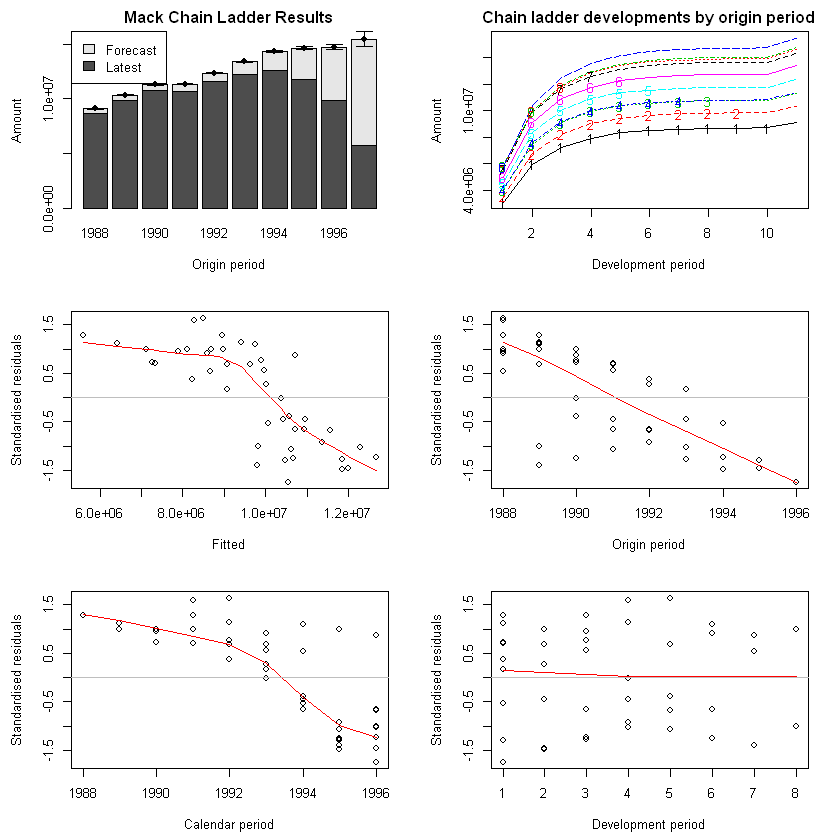

In [44]:
plot(MackCL)

Plots six different graphs starting from the top left with a stacked bar-chart of the latest claims position plus IBNR and Mack’s standard error by origin period; next right to it is a plot of the forecasted development patterns for all origin periods (numbered, starting with 1 for the oldest origin period), and 4 residual plots. The residual plots show the standardized residuals against fitted values, origin period, calendar period and development period.

The residual plots should be scattered with no pattern or direction for Mack’s method of calculating the standard error to apply. Patterns could be a result of a trend that should be investigated further. More information on that can here found here.

We can plot the development, including the forecast and estimated standard errors by origin period by setting the argument lattice=TRUE.

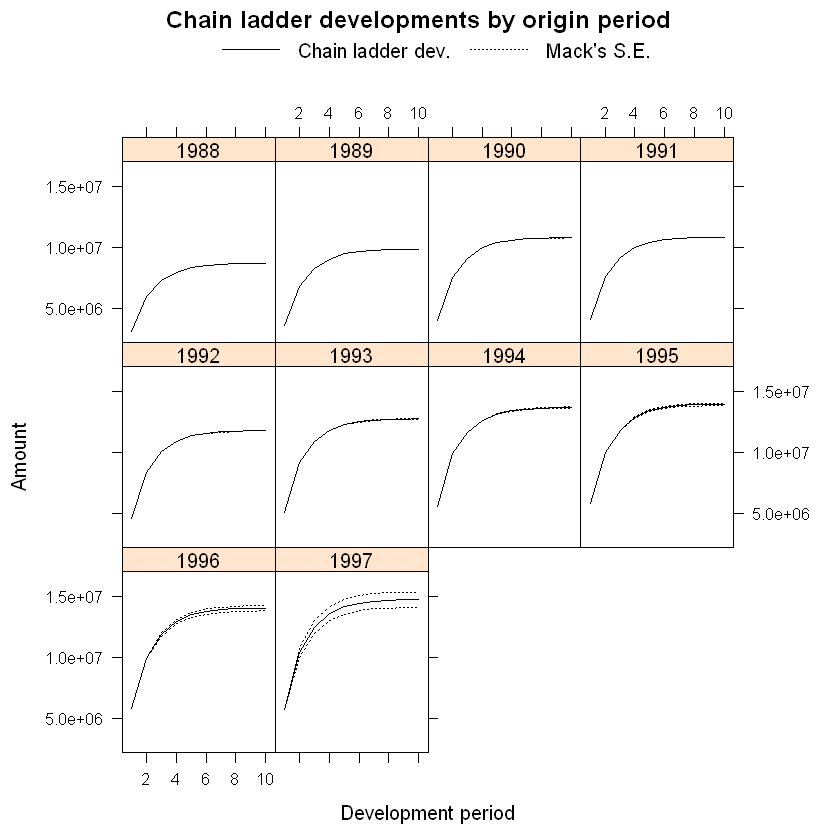

In [45]:
plot(MackCL, lattice=TRUE)